# Project 2, Feed Forward Neural Network
## Setup

In [60]:
# NN imports

import seaborn as sns
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [61]:
## FFNN with backpropagation, sigmoid activation function
## Franke function data, compare to project 1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#np.random.seed(10)

# Functions
def R2(y_data, y_model): #score function
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model): #mean square error
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def FrankeFunction(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n): 
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

# Noisy Franke plot from Project 1
N = 40
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

x_, y_ = np.meshgrid(x,y)

var = 0.1 # Variance of noise 
noise = np.random.normal(0, var, len(x_)*len(x_)) 
noise = noise.reshape(len(x_), len(x_))

z = FrankeFunction(x_, y_) + noise #Franke with added noise

In [62]:
## Prepare data like for linear regression (?)
## Should the design matrix be prepared differently?

n = 5 # Regression polynomial degree (this affects the approximate terrain plot below)
X = create_X(x_, y_, n) # Construct design matrix

H = (2.0/(N)) * X.T @ X # Hessian matrix
EigVal, EigVec = np.linalg.eig(H)
print(f"The eigenvalues of Hessian matrix are: \n {EigVal}")

# We split the data in training (80%) and test (20%) data
X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z).reshape(-1,1), test_size=0.2)

The eigenvalues of Hessian matrix are: 
 [1.95667702e+02 2.90021629e+01 1.89833200e+01 2.53767904e+00
 1.70163555e+00 1.11179778e+00 1.61319247e-01 7.27244637e-02
 4.60413586e-02 3.53205271e-02 6.06554587e-03 2.06994900e-03
 1.14138979e-03 7.71454272e-04 5.89666969e-04 1.07287106e-04
 2.59448666e-05 2.92195768e-06 5.31451014e-06 7.51870260e-06
 1.14645645e-05]


The eigenvalues are all positive values, meaning the Hessian is positive definite. This also means that the cost function will not have any local minima that can disturb the gradient descent later. (?)

## Building feed forward neural network

In [63]:
# Building our neural network (borrowed, lect notes 14.2.4)
# Initialization

n_inputs, n_features = X_train.shape
n_hidden_neurons = 20 #start with few neurons
h = 1 #nr of hidden layers
n_categories = 1

In [64]:
## Feed-forward pass

# Sigmoid modified to prevent numerical errors for large x
def sigmoid(x):
    if x >= 0:
        return 1 / (1 + np.exp(-x))
    else:
        z = np.exp(x)
        return z/(1+z)
sigmoid = np.vectorize(sigmoid)

# implement if statement for different activation
def feed_forward(X): # modified for regression
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) 
    # activation in the hidden layer 
    a_h = sigmoid(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights)
    
    return a_h, z_o

This is a poor first guess, but back propagation with gradient descent should approach a good fit given enough epochs. MSE as cost function.

In [69]:
## Back propagation (also borrowed from lecture notes)
## Continue until cost function converges

from sklearn.metrics import accuracy_score

# we make the weights normally distributed using numpy.random.randn
# weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, n_hidden_neurons)*0.01
hidden_bias = np.zeros((1,n_hidden_neurons)) + 0.01
# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)*0.01
output_bias = np.zeros((1,n_categories)) + 0.01

# weights scaled down because of small z values (max vals of scale of order 10^0)
# miltyplied with *1 means the gradient descent needs a lot of epochs to converge

def backpropagation(X, Y):
    a_h, z_o_ = feed_forward(X)
    
    # error in the output layer
    # scaled with amount of data to prevent numerical errors at large generated weights
    error_output = (z_o_ - Y)/Y.shape[0]
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient, z_o_

# Regression with FFNN and backpropagation
epochs = 100
MSE_NN = np.zeros(epochs)
eta = 0.01
lmbd = 0.01
for i in range(epochs):
    # calculate gradients
    dWo, dBo, dWh, dBh, z_o_ = backpropagation(X_train, z_train)
    
    # regularization term gradients
    dWo += lmbd * output_weights
    dWh += lmbd * hidden_weights
    
    # update weights and biases
    output_weights -= eta * dWo
    output_bias -= eta * dBo
    hidden_weights -= eta * dWh
    hidden_bias -= eta * dBh
    
    # save mse for each step
    MSE_NN[i] = MSE(z_train, z_o_)

#print("New accuracy on training data: " + str(accuracy_score(predict(X_train), z_train)))

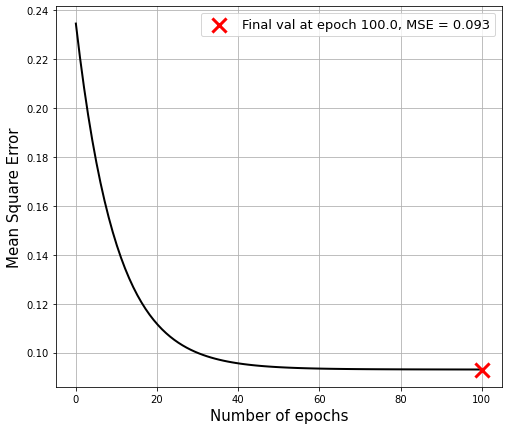

In [70]:
# Evaluate
#MSE_NN = MSE(z_train, outputs)
epoch = np.linspace(0, epochs, epochs)

## Plotting MSE for each epoch 
fig = plt.figure(figsize = (8, 7))
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Mean Square Error', fontsize = 15)
plt.plot(epoch, MSE_NN, 'k', lw = 2)
plt.scatter(epoch[-1], MSE_NN[-1], color = 'r', marker = 'x', lw = 3, s = 200,
            zorder = 2, label = f'Final val at epoch {epoch[-1]}, MSE = {round(MSE_NN[-1], 3)}')
plt.grid(1); plt.legend(prop={'size': 13}); plt.show()

Appears to converge around MSE = 0.08, which is worse performance than our OLS analysis in proj1.

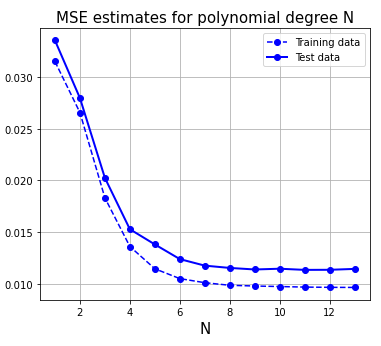
Above: results from ordinary least squares regression in project 1